<a href="https://colab.research.google.com/github/Pravin1Borate/NLP_Case_Studies/blob/main/Part_Of_Speech_And_Topic_Modeling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Situation: Data Scientist @ Amazon

Today we will tackling a very common type of EDA/Insight discovery problem, where you've been given a lot of text, and you just have to figure out what is being talked about.

In amazon, where let's say you're a data scientist at, reviews are a very important source of information. Lot's of sellars use it to figure what are the issues customers are facing, how to fix them, how to improve products etc. Amazon wants sellers to improve too, as if thier sales improves, amazon's revenue also goes up.

## Problem Statement: what is being talked about in reviews?
You are working in the Musical Instruments department, and you've recently recieved a request to use review data, and figure out **what is being talked about**, and give that insight to sellers so they could possibly improve thier products.

### Things to keep in mind:
What do you think a solution to this would look like?

1. A ppt you show to the sellers?
2. A wordcloud of the what is being talked about in the reviews?
3. A list of topics?
4. A list of phrases/words being used?

If you were a sellar what would you be looking forward to?

Each type of solution has it's pros and cons.

1. Some are easy to do, but hard to correctly understand
   1. Example: Wordcloud. Wordcloud is easy to do, but it's very difficult to gain usable insight from it.
2. Some are easy to digest and consume, but hard to do correctly
   1. A list of topics: Very to easy to understand, but how would you generate these topics?

### Downloading Data

In [1]:
!gdown 1gGazb-hGBiJnVy4WCoWFOFfzPdhlmqrV

Downloading...
From: https://drive.google.com/uc?id=1gGazb-hGBiJnVy4WCoWFOFfzPdhlmqrV
To: /content/Musical_Instruments_5.json
100% 7.45M/7.45M [00:00<00:00, 56.3MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
review_data = pd.read_json('/content/Musical_Instruments_5.json',lines=True)
review_data.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"


In [4]:
review_data["reviewTime"] = pd.to_datetime(review_data["reviewTime"], format="%m %d, %Y")

<Axes: >

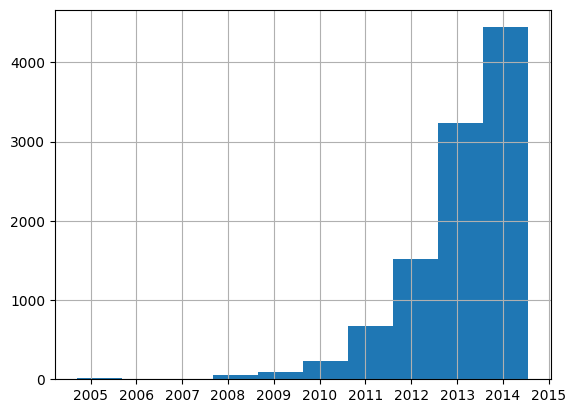

In [5]:
review_data['reviewTime'].hist()

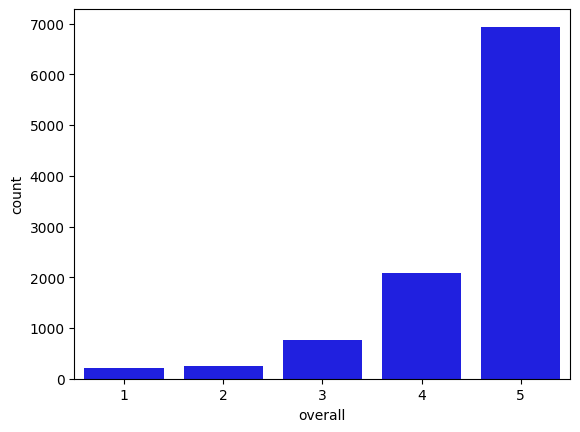

In [6]:
sns.countplot(data=review_data,x='overall',color='blue');

Since we're not really concerned with the sentiment or ratings, for this problem statement we'll only be focusing on the review content

## What if we just count words?

What are the things being talked about in the reviews?

Let's first try a simple word counter, and see the top 10 words?

In [7]:
from collections import Counter

def flatten(list_of_lists):
    flat_list = []
    for l in list_of_lists:
        flat_list.extend(l)
    return flat_list

Let's install NLTK, spacy and wordcloud

In [ ]:
import nltk
nltk.download('all')

In [9]:
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [10]:
def wordcloud_plot(counter_all):
    w = WordCloud().generate_from_frequencies(frequencies=dict(counter_all))
    plt.imshow(w)

def tokenize(text):
    tokens = [w for w in word_tokenize(text.lower())]
    return tokens

In [11]:
counter_all = Counter(flatten(review_data['reviewText'].apply(tokenize).tolist()))
counter_all.most_common(10)

[('.', 47091),
 ('the', 44092),
 (',', 35705),
 ('i', 30997),
 ('a', 27895),
 ('and', 26984),
 ('it', 24119),
 ('to', 23038),
 ('is', 14943),
 ('of', 13588)]

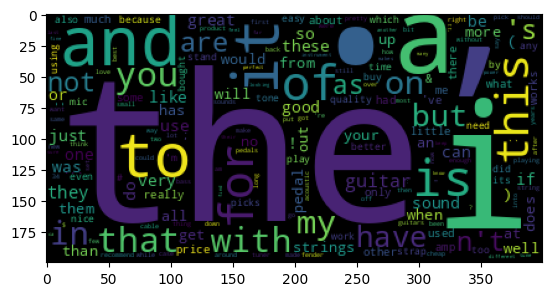

In [12]:
wordcloud_plot(counter_all)

### The 10 most **common words seem to all be stop words** and/or punctuations.

The wordcloud also doesn't look very useful

# What if we remove stopwords?
Let's try and improve this with a simple stopword and punctuation remover, and using better word tokenization

In [13]:
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))
# english_stopwords

In [14]:
def tokenize_clean(text):
    tokens = [w for w in word_tokenize(text.lower()) if w not in english_stopwords and w.isalpha()]
    return tokens

In [15]:
counter_all = Counter(flatten(review_data["reviewText"].apply(tokenize_clean).tolist()))
counter_all.most_common(10)

[('guitar', 5472),
 ('one', 4402),
 ('great', 4026),
 ('like', 3897),
 ('use', 3724),
 ('good', 3720),
 ('sound', 3507),
 ('strings', 3349),
 ('well', 3042),
 ('get', 2657)]

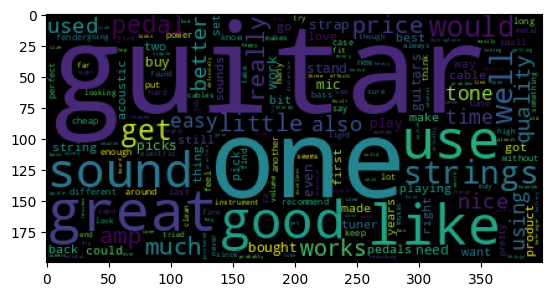

In [16]:
wordcloud_plot(counter_all)

Much better now, but still **not very informative**, considering we care about **"what"** people are talking about.

### Most of the words seem to be about how someone "liked" something, or something was "good".

The wordcloud also looks much better!

#### The only useful things we got are "guitar" and "strings"...

## Wait, why don't we just filter in "useful" words?


Can we remove these "not useful" words? We know that all these reviews are in English, can we use some English Grammer concepts here?

### What if we extract all Nouns from the reviews?

We can do this using spacy:

First, let's install spacy, and the english models for spacy

In [17]:
import spacy
nlp = spacy.load('en_core_web_sm')

#### Let's take the first review and use spacy on it

In [18]:
review_sample = review_data['reviewText'].iloc[0]
review_sample

"Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,"

In [19]:
spacy_process_review = nlp(review_sample)
spacy_process_review

Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,

From the first glance, it looks similar, except the quotes (") have dissapeared. In fact, after processing, **spacy does NOT return a string object, but a custom spacy Document object!**

In [20]:
type(spacy_process_review)

spacy.tokens.doc.Doc

Similarly, **each word in the document isn't a simple string either, but a Token object**! So spacy has done tokenisation and stuff for us already.

Each token object also has a lot of useful properties that we can use.

In [21]:
spacy_process_review[0], type(spacy_process_review[0])

(Not, spacy.tokens.token.Token)

Here, we can get the part of speech (i.e. grammer classification) of each word. The word "Not" here, is a particle, denoted by "PART". But let's look for all Nouns!

### How are these Part of Speech (POS) tags generated, though? What is spacy doing?

Spacy is using it's english pre-trained model, which was trained using tagged tree-bank data.

This tree-bank dataset contains the POS tag for every word, and these datasets were labelled manually.

1. Model used could be Probabalistic HMM (Hidden Markov Model), which can be trained using a DP algo called Viterbi Algo
2. Model could also be a sequential neural network like RNN (Recurrent Neural Network), trained using backpropogation


#### Spacy recognises Noun as "NOUN" and proper nouns (names of spceific things like people, cities etc.) as seperate "PROPN"

In [22]:
spacy_process_review[0].pos_

'PART'

Awesome! Now we can see the POS tags int this review, we can see that is talking about pop-sounds, recording, prices & filters, by just looking at the Nouns

In [23]:
for tok in spacy_process_review:
    if tok.pos_ in ["NOUN", "PROPN"]:
        print(tok, "-->", tok.pos_)

filters --> NOUN
pop --> NOUN
sounds --> NOUN
recordings --> NOUN
prices --> NOUN
filters --> NOUN
amazon --> PROPN
pricing --> NOUN


But we're still missing out on a lot of context, especially like "pop" and "sounds" are actually just parts of ONE thing, "pop sounds".

### It's not just the noun words we need... but entire NOUN PHRASE

### We can achieve this by using constituency parsing.

Constituency parsing uses hand built rules. **These rules are often written usin CFG (Context Free Grammer) and Finite Automoata concepts.**

The rules could be something simple like "NP -> Noun Noun". This basically means that 2 Nouns together, constitutes a Noun Phrase (NP)

In reality though, it would look something like this, and be resolved using CFG rules
```
NP -> Noun
NP -> PropN
NP -> Adj [Adp] NP
```

If you use spacy, though, you don't need to worry about writing your own rules for getting Noun Phrases.

### Spacy, treats pronouns as nouns as well.
While useful in many scenarios, we need to remove these noun chunks.
#### Let's exclude all noun chunks which have no NOUN or PROPN.

Spacy gives the "most expansive", i.e. largest viable noun chunks. This can be very useful in many situation, however ours isn't really one of them.
Let's also remove the non-noun parts of the noun-phrase, as our use case doesn't really need that.

In [24]:
for c in spacy_process_review.noun_chunks:
    print(c, [t.pos_ for t in c])

it ['PRON']
exactly what ['ADV', 'PRON']
it ['PRON']
filters ['NOUN']
the pop sounds ['DET', 'NOUN', 'NOUN']
my recordings ['PRON', 'NOUN']
it ['PRON']
the lowest prices ['DET', 'ADJ', 'NOUN']
filters ['NOUN']
amazon ['PROPN']
it ['PRON']
they ['PRON']
their pricing ['PRON', 'NOUN']


In [25]:
noun_checker = lambda x: any()

In [26]:
for c in spacy_process_review.noun_chunks:
    new_nc = [t.text for t in c if t.pos_ in ["NOUN", "PROPN"]]
    if new_nc:
        print(new_nc)

['filters']
['pop', 'sounds']
['recordings']
['prices']
['filters']
['amazon']
['pricing']


Looks much better now!

#### Let's also filter out the non-noun words from the noun-phrase

Before we move on, let's run this on all our reviews once, and see the results

In [27]:
def get_noun_phrases(text):
    doc = nlp(text)
    required_nc = []
    for c in doc.noun_chunks:
        new_nc = [t.text for t in c if t.pos_ in ["NOUN", "PROPN"]]
        if new_nc:
            new_nc_text = " ".join(new_nc)
            required_nc.append(new_nc_text)
    return required_nc

In [28]:
from tqdm.auto import tqdm
tqdm.pandas()

In [29]:
review_data["noun_phrases"] = review_data["reviewText"].progress_apply(get_noun_phrases)

  0%|          | 0/10261 [00:00<?, ?it/s]

In [30]:
review_data["noun_phrases"]

0        [filters, pop sounds, recordings, prices, filt...
1        [product, bonus, screens, hint, smell, grape c...
2        [job, device, breath, popping sound, voice, re...
3        [pops, thing, gooseneck, screen, position, pos...
4                [pop filter, studio filter, vocals, pops]
                               ...                        
10256                                                   []
10257    [Nanoweb strings, while, price, strings, comme...
10258    [strings, past, Elixirs, disconnect, guitar, c...
10259    [Elixir, DEVELOPED, Taylor Guitars, strings, R...
10260    [strings, strings, complaint, strings, strings...
Name: noun_phrases, Length: 10261, dtype: object

#### Now this looks much better!
#### It seems like most people are talking about the guitars, strings, the pricing, how they sound, how much amp the devices have, thier tones etc.

Much more useful than the previous iterations!

In [31]:
counter_all = Counter(flatten(review_data["noun_phrases"].tolist()))
counter_all.most_common(10)

[('guitar', 3172),
 ('strings', 2543),
 ('price', 1793),
 ('sound', 1746),
 ('pedal', 1517),
 ('one', 1355),
 ('amp', 1159),
 ('time', 1103),
 ('tone', 1029),
 ('guitars', 987)]

But... these still aren't very actionable.
#### For example, we still don't know what are people talking about regarding guitars? What word/words is it related to?

### For this, we can use something called as Dependency Parsing.

In Dependecny Parsing, each SENTENCE is converted to a TREE, where every word is connected to some other words based on "grammatical closeness"

### Dependency trees can be visualized at (https://explosion.ai/demos/displacy).

Here, the arrows represent a parent-child relationship. Here the is an arrow "love" --> "learning" would imply "love" is the parent of "learning"

Let's take a sample sentence and see it's dependencies.

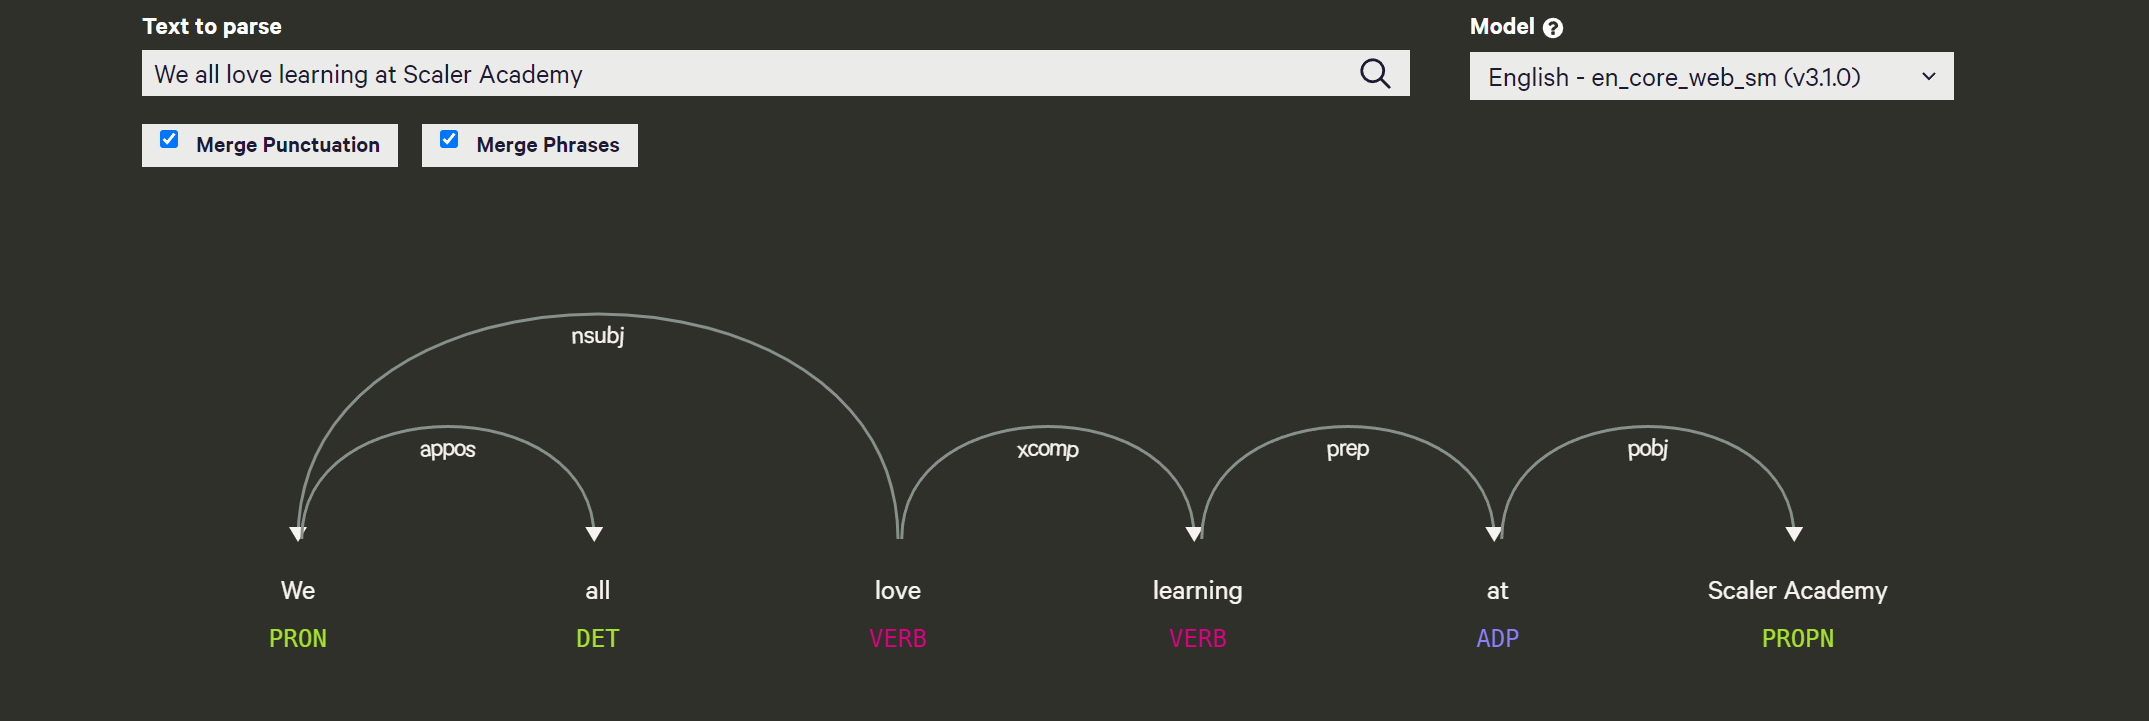

Here, the word "love" has no arrows pointing towards it, making it the ROOT of the tree, (i.e. it has no parent). The ROOT is almost always the main VERB (action). In this example, "love" is the main action, with "love learning" being the main Verb Phrase.

There is a connection of "love" --nsubj--> "We"

This means "We" is a child of the word "love". In dependency parsing, every parent child relationship has a unique label, which signifies the type of the relationship. This is called as the "dependency type".

Here, the dependecy type is nsubj. nsubj represents the subject or the thing doing the action or the "who" of the action. i.e. Who does "love learning"? "We" does.

Similarly, the "learning" --prep--> "at" has the dependency type "prep" which shows "where". The "at" --pobj--> "Scaler Academy" finished the "where" question. i.e. Where does "love learning" happen? "At". "At" where? "At" "Scaler Academy".

BTW all POS tags and Dependency labels can be found at https://spacy.io/models/en#en_core_web_sm-labels

### Now, let's try to just get the parent of all the noun phrases we got, and attach them?

In [32]:
def get_noun_phrases_parent(text):
    doc = nlp(text)
    required_nc = []
    for c in doc.noun_chunks:
        nc_parent = c.root.head
        new_nc = [t.text for t in c if t.pos_ in ["NOUN", "PROPN"]]
        if new_nc:
            new_nc_text = " ".join(new_nc) + "->" + nc_parent.text
            required_nc.append(new_nc_text)
    return required_nc

In [33]:
review_data["noun_phrases_parent"] = review_data["reviewText"].progress_apply(get_noun_phrases_parent)

  0%|          | 0/10261 [00:00<?, ?it/s]

In [34]:
counter_all = Counter(flatten(review_data["noun_phrases_parent"].tolist()))
counter_all.most_common(10)

[('price->for', 580),
 ('years->for', 501),
 ('guitar->on', 396),
 ('thing->is', 356),
 ('strings->are', 276),
 ('pedal->is', 259),
 ('tune->in', 254),
 ('guitar->of', 253),
 ('job->does', 250),
 ('strings->of', 238)]

### Hmm that turned out to not be adding much information for our purpose
We can try more things, for example also looking at at the dependency type of the noun phrase, looking at thier siblings, (i.e. the words that are connected to the parent noun phrase, but not the noun phrase itself).

Also, do notice that the counts are now much lower, earlier "guitar" had occoured nearly 3000 times, but now the most common set is only at 500 times.

## Why don't we directly extract the Topic being talked about?
### Topic Modelling

Maybe we should try to figure out what are topics present in the reviews first?

### But what is a topic in the first place?

#### Let's define a topic as a set of words that are related to each other in soome way.


Example Topic "Animals": "Dog", "Cat", "Bird", "Fish" etc.

But these topics could also be really conceptually complex and specific.

Ex: "Programming Languages used for ML": "Python, R, Scala, Julia"

Thus, any arbitrary set of words can be a topic, as long as they're at least somewhat related to each other.

Also, there is no constraint that one word can only be a part of one topic. One word could be realted to multiple topics.

<!-- 1. Every review will have some set of topics being talked about in it
2. For example: Topics could be: "Guitar", "Pitch", "Sound", "Sturdiness" etc.
3. Each review could be defined as: 50% "Guitar" + 20% "Pitch" + 20% "Sound" + 10% "Sturdiness" etc.
4. Each topic will have a collection of words that are related to it
5. Because that's how we've defined a topic
6. Using each topic, we will "generate" the review.  -->


Can we exploit this definition of a topic somehow? What would a review be, in terms of topics?

### Could we define a review as a set of topics? Let's say Topics could be: "Guitar", "Amp", "Sound", "Price", "Tone" etc.

Let's first imagine the review as just a bag of words, where order doesn't matter. Could we collect words such that all words would be coming from a topic, as a topic is nothing but a set of words?

If we're able to put 50% of words to "Guitar" topic, 20% to "Amp", could we define the review to be a simple collection of topics?

A review could be defined as something like: 50% "Guitar" + 20% "Amp" + 20% "Sound" + 5% "Price" etc.?


![img](https://miro.medium.com/max/1050/1*2uj6t3gNv76SpHrWf5-z-A.jpeg)

This re-definition of a review/document forms the very basis of a concept called as "Topic Modelling" where we try to find the topics in a set of document, by redifining the documents as a set of topics instead of a set of words.

### Let's use the topic definition for directly extracting topics
LDA or Latent Dirichlet Allocation is a topic modelling algorithm, and one of the simplest topic modelling algorithms.

In this, we model this document->topic and topic->word allocation as probability distributions, specifically Dirichlet distributions.

<!-- For example: Let's assume we have a topic like `Guitar, Violin, Sita, Harp`. Remember, a topic is just a set of interconnected words.  -->

<!-- We have a prior hyper-parameters which we use initialize, for both Document->topic and Topic->word distributions. -->

We use 2 hyper-params $\alpha$ and $\eta$, which we use to initialize Document-Topic distribution and Topic-word distributions respectively

## An analogy of LDA could be like this:
1. Let's say we have to extract 3 topics from a set of documents.
2. Let's imagine we have a basket, corrosponding to which topic goes in what document
   1. For each document, we would pick some balls (say 10) from this topic. Each ball represents a topic.
   2. If say, 8/10 balls belong to **Sport** topic, and 2/10 balls belong to **Animals** topic, we'd say that the document is 80% **Sport** + 20% **Animals**
   3. The "person" who sets and initialises how many balls of each topic into the basket is $\alpha$, our hyperparamter
3. Let's imagine we have 3 more baskets, each of them corrosponding to one of the topics.
   1. In each basket, we have some balls, with each ball corrosponding to a word. There could be multiple or 0 balls for any word in a basket, and the same word ball can be in several baskets
   2. Each basket can contain different proportions of each ball, example the basket for the topic **Sport** might contain many balls for *Olympics*, *Playing*, *Cricket* etc. But it would probably not contain any ball for *Cats*
   3. The "person" who sets and initialises which balls go into each basket is $\eta$, our second hyperparamter
4. We re-imagine the document creation process using these baskets. Recall, that in LDA we consider the document as just a bag of words, without any order.
   1. For every document, we pick up some number of balls (say 10) from the topics basket. Let's say we got 8/10 from **Sport** and 2/10 from **Animals**
   2. We'll then go *8* times to the **Sport** Basket, and pick up some word balls (say 10) each time we go to the basket. We'd also go to *2* times to the **Animals** basket, picking up the same number of word balls for that document.
   3. Now, for the document we have the bag-of-words we'd get using the current topic assigned.
5. We can now compare this generated bag-of-words document to our existing bag-of-words document.
   1. We can now use this comparision to come up with something analagous to a loss function, and optimise the baskets to minimise this loss function.

![img](https://miro.medium.com/max/1050/1*fCc0JT3W-1ViYyw0hJ7rdA.jpeg)

Below is a more technical version of the same algo, for a better understanding of the document generation process
Given
- $k$: Number of Topics
- $V$: Number of unique words (Vocabulary)
- $M$: Number of documents
- $N$: Number of words in each document
- $M^{\prime}: M \times N \times V$: One-Hot Matrix of Bag of Word Documents
  - $M$ documents, each containing $N$ words, where every one of $N$ words in the document be one of $V$ unique words

Process:
1. We use $\alpha$ to initialize $\theta$. $\theta$ is a probablity distribution matrix (size $k \times N$ ), where every $\theta_{i,j}$ is the probability of topic $j$ being in document $i$
   1. Similar to sampling from first basket above.
2. For a single document (i.e. one row of $theta$) we sample the topic for each of the $N$ words for the document using it's row in $\theta$. Each word is assigned to a topic, based on the row from $\theta$. We call this One-hot matrix $z$
3. We also use $\eta$ to initialize $\beta$. $\beta$ is a probablity distribution matrix (size $k \times V$ ), where every $\beta_{i,j}$ is the probability of word $j$ being in topic $i$
   1. Similar to sampling from each baskets above.
4. Now, we can use $z$ and $\beta$ to sample the bag of words document. For each word in $N$, we sample the word from $\beta$ using the topic it was assigned to in $z$, generating the final document matrix $N \times V$
5. We do steps 2-4 for each document in $M$, generating a $N \times V$ matrix each time. We finally obtain the $M \times N \times V$ generated documents.
6. We can now compare and optimize this process using the document matrix we already had

![img](https://miro.medium.com/max/1050/1*WGsNq9tjIwhGMCEthvAmVw.jpeg)

For the optimization process, we usually use KL divergence as the Loss function.

For the sampling process, we use the drichlet distribution to get $\theta$ from $\alpha$. Drichlet distribution is a distribution used when you want to get probabilities in a category.


Below are several visulaization of drichlet distribution at different $\alpha$ for 3 topics

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Dirichlet.pdf/page1-1125px-Dirichlet.pdf.jpg)

### Doing ALL of the above in python

Okay... how would you do use this in practice? We can just directly use the `gensim` library's LDA implimentation

In [35]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

### Let's first convert the data into a bag of words document matrix, so we can pass it to the LDAModel.

For this, we'd have to build, the vocabulary, i.e. set of unique words. We can then use this Vocab to convert each document to bag of words.

However, genesim's LDA models don't directly deal with strings, they take list of strings, i.e. pre-tokenized documents.

Let's use the same tokenized and stopword removed, we first used.

In [36]:
tokenized_clean_reviews = review_data["reviewText"].apply(tokenize_clean)

In [37]:
tokenized_clean_reviews

0        [much, write, exactly, supposed, filters, pop,...
1        [product, exactly, quite, realized, double, sc...
2        [primary, job, device, block, breath, would, o...
3        [nice, windscreen, protects, mxl, mic, prevent...
4        [pop, filter, great, looks, performs, like, st...
                               ...                        
10256                             [great, expected, thank]
10257    [thinking, trying, nanoweb, strings, bit, put,...
10258    [tried, coated, strings, past, including, elix...
10259    [well, made, elixir, developed, taylor, guitar...
10260    [strings, really, quite, good, would, call, pe...
Name: reviewText, Length: 10261, dtype: object

In [38]:
vocabulary = Dictionary(tokenized_clean_reviews)
vocabulary

### We can then directly use the `doc2bow` of the vocabulary to convert the document to a BOW

In [39]:
bag_of_words_documents = [vocabulary.doc2bow(text) for text in tokenized_clean_reviews]
# bag_of_words_documents

Let's train for 10 topics now!

In [40]:
lda = LdaModel(bag_of_words_documents,
               num_topics=10,
               id2word=vocabulary)

And let's see the topics.

### The number in front of each word represents the *contribution* of each word in that topic.

### Looks like the topics are about Mics, Guitars, Guitar Capos, Guitar picks, Tuning, Pedels and Amp etc.

### This definetly helps us answer "What is being talked about in the reviews?"!

In [41]:
lda.print_topics()

[(0,
  '0.032*"amp" + 0.030*"pedal" + 0.022*"snark" + 0.019*"looper" + 0.012*"sound" + 0.011*"pedals" + 0.010*"echo" + 0.010*"get" + 0.009*"great" + 0.008*"power"'),
 (1,
  '0.023*"stand" + 0.022*"guitar" + 0.016*"great" + 0.013*"good" + 0.013*"one" + 0.010*"well" + 0.010*"would" + 0.010*"quality" + 0.009*"mic" + 0.008*"case"'),
 (2,
  '0.032*"strings" + 0.026*"sound" + 0.021*"tone" + 0.013*"like" + 0.010*"pedal" + 0.010*"good" + 0.009*"great" + 0.009*"get" + 0.008*"set" + 0.008*"play"'),
 (3,
  '0.015*"guitar" + 0.011*"like" + 0.010*"use" + 0.009*"good" + 0.009*"get" + 0.009*"great" + 0.008*"sound" + 0.008*"really" + 0.008*"one" + 0.007*"recording"'),
 (4,
  '0.013*"one" + 0.011*"capo" + 0.010*"use" + 0.010*"like" + 0.010*"guitar" + 0.008*"picks" + 0.008*"great" + 0.007*"time" + 0.007*"used" + 0.007*"pick"'),
 (5,
  '0.019*"tuner" + 0.015*"guitar" + 0.014*"one" + 0.012*"string" + 0.011*"tune" + 0.011*"use" + 0.011*"well" + 0.009*"tuning" + 0.008*"strings" + 0.008*"like"'),
 (6,
  '0.0

In [ ]:
!pip install pyLDAvis

In [43]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, bag_of_words_documents, dictionary=lda.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.033486  0.041294       1        1  20.500143
4     -0.016332  0.048697       2        1  18.562831
7      0.117757 -0.019185       3        1  13.964970
5     -0.028701  0.091322       4        1  12.340819
2     -0.070241 -0.084989       5        1   9.614464
1      0.009508  0.085172       6        1   9.105664
6      0.021405  0.126007       7        1   6.169118
0      0.103439 -0.153592       8        1   5.027159
9     -0.217363 -0.064451       9        1   2.825330
8      0.047043 -0.070275      10        1   1.889501, topic_info=          Term         Freq        Total Category  logprob  loglift
885    strings  3892.000000  3892.000000  Default  30.0000  30.0000
187      pedal  2335.000000  2335.000000  Default  29.0000  29.0000
161        amp  2245.000000  2245.000000  Default  28.0000  28.0000
92       sound  3547.000000  3547.000000  Default  27.0000  27.0000
2416      capo  1547.000000  1547.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
44     product    35.135172   892.285864  Topic10  -5.4631   0.7343
134       good    35.801623  3665.039767  Topic10  -5.4444  -0.6597
127     bought    32.660622  1038.700910  Topic10  -5.5362   0.5093
289     really    32.431084  2251.789140  Topic10  -5.5432  -0.2715
303   acoustic    30.914268  1021.244162  Topic10  -5.5911   0.4713

[800 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3764      1  0.021031      ac
3764      3  0.073609      ac
3764      4  0.052578      ac
3764      8  0.830726      ac
3764     10  0.010516      ac
...     ...       ...     ...
160      10  0.024559   years
5599      4  0.936973     yep
4575      3  0.977171    yeti
6576      4  0.979488    zing
4759      3  0.944354  zipper

[2586 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 8, 6, 3, 2, 7, 1, 10, 9])

### Conclusion
- Parts Of Speech tagging marks a word in the text as corresponding to a particular part of speech.
- Spacy internally uses Probabilistic HMMs or Sequential Neural Nets to perform POS tagging.
- Constituency parsing & Dependancy trees can be used for topic modeling. However, their performance and capacity are limited.
- Latent Dirichlet Algorithm is a simple, yet powerful algorithm for topic modeling.